Name: Willard Ford

Group number: 4

Instructions:

To start working on this Homework Assignment, create a copy of this notebook and save it within your Google Drive (File -> Save a copy in Drive).

This Jupyter notebook contains 2 exercises consisting of coding and discussion questions. For the discussion questions, please write your answer inside a new text cell. Please hand in your .ipynb file (File -> Download -> Download .ipynb) on canvas by 8pm on May 19th.

To execute the code, it is necessary to load some external packages, so please execute the following code blocks.

In [2]:
# @title Install the Brian2 package
!pip install brian2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.0 MB/s eta 0:00:00


In [1]:
# @title import packages
from random import sample
import numpy as np
import numpy.random as rnd
import math
from math import floor
from collections import deque
from scipy.special import erf
from numpy.fft import rfft, irfft
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
import matplotlib.pyplot as plt
import time

b2.defaultclock.dt = 0.05 * b2.ms

In [2]:
# @title Functions to help you plot your results

def plot_network_activity(rate_monitor, spike_monitor, voltage_monitor=None, spike_train_idx_list=None,
                          t_min=None, t_max=None, N_highlighted_spiketrains=3, avg_window_width=1.0 * b2.ms,
                          sup_title=None, figure_size=(10, 4)):
    """
    Visualizes the results of a network simulation: spike-train, population activity and voltage-traces.

    Args:
        rate_monitor (PopulationRateMonitor): rate of the population
        spike_monitor (SpikeMonitor): spike trains of individual neurons
        voltage_monitor (StateMonitor): optional. voltage traces of some (same as in spike_train_idx_list) neurons
        spike_train_idx_list (list): optional. A list of neuron indices whose spike-train is plotted.
            If no list is provided, all (up to 500) spike-trains in the spike_monitor are plotted. If None, the
            the list in voltage_monitor.record is used.
        t_min (Quantity): optional. lower bound of the plotted time interval.
            if t_min is None, it is set to the larger of [0ms, (t_max - 100ms)]
        t_max (Quantity): optional. upper bound of the plotted time interval.
            if t_max is None, it is set to the timestamp of the last spike in
        N_highlighted_spiketrains (int): optional. Number of spike trains visually highlighted, defaults to 3
            If N_highlighted_spiketrains==0 and voltage_monitor is not None, then all voltage traces of
            the voltage_monitor are plotted. Otherwise N_highlighted_spiketrains voltage traces are plotted.
        avg_window_width (Quantity): optional. Before plotting the population rate (PopulationRateMonitor), the rate
            is smoothed using a window of width = avg_window_width. Defaults is 1.0ms
        sup_title (String): figure suptitle. Default is None.
        figure_size (tuple): (width,height) tuple passed to pyplot's figsize parameter.

    Returns:
        Figure: The whole figure
        Axes: Top panel, Raster plot
        Axes: Middle panel, population activity
        Axes: Bottom panel, voltage traces. None if no voltage monitor is provided.
    """

    assert isinstance(rate_monitor, b2.PopulationRateMonitor), \
        "rate_monitor  is not of type PopulationRateMonitor"
    assert isinstance(spike_monitor, b2.SpikeMonitor), \
        "spike_monitor is not of type SpikeMonitor"
    assert (voltage_monitor is None) or (isinstance(voltage_monitor, b2.StateMonitor)), \
        "voltage_monitor is not of type StateMonitor"
    assert (spike_train_idx_list is None) or (isinstance(spike_train_idx_list, list)), \
        "spike_train_idx_list is not of type list"

    all_spike_trains = spike_monitor.spike_trains()
    if spike_train_idx_list is None:
        if voltage_monitor is not None:
            # if no index list is provided use the one from the voltage monitor
            spike_train_idx_list = np.sort(voltage_monitor.record)
        else:
            # no index list AND no voltage monitor: plot all spike trains
            spike_train_idx_list = np.sort(all_spike_trains.keys())
        if len(spike_train_idx_list) > 5000:
            # avoid slow plotting of a large set
            print("Warning: raster plot with more than 5000 neurons truncated!")
            spike_train_idx_list = spike_train_idx_list[:5000]

    # get a reasonable default interval
    if t_max is None:
        t_max = max(rate_monitor.t / b2.ms)
    else:
        t_max = t_max / b2.ms
    if t_min is None:
        t_min = max(0., t_max - 100.)  # if none, plot at most the last 100ms
    else:
        t_min = t_min / b2.ms

    fig = None
    ax_raster = None
    ax_rate = None
    ax_voltage = None
    if voltage_monitor is None:
        fig, (ax_raster, ax_rate) = plt.subplots(2, 1, sharex=True, figsize=figure_size)
    else:
        fig, (ax_raster, ax_rate, ax_voltage) = plt.subplots(3, 1, sharex=True, figsize=figure_size)

    # nested helpers to plot the parts, note that they use parameters defined outside.
    def get_spike_train_ts_indices(spike_train):
        """
        Helper. Extracts the spikes within the time window from the spike train
        """
        ts = spike_train/b2.ms
        # spike_within_time_window = (ts >= t_min) & (ts <= t_max)
        # idx_spikes = np.where(spike_within_time_window)
        idx_spikes = (ts >= t_min) & (ts <= t_max)
        ts_spikes = ts[idx_spikes]
        return idx_spikes, ts_spikes

    def plot_raster():
        """
        Helper. Plots the spike trains of the spikes in spike_train_idx_list
        """
        neuron_counter = 0
        for neuron_index in spike_train_idx_list:
            idx_spikes, ts_spikes = get_spike_train_ts_indices(all_spike_trains[neuron_index])
            ax_raster.scatter(ts_spikes, neuron_counter * np.ones(ts_spikes.shape),
                              marker=".", c="k", s=15, lw=0)
            neuron_counter += 1
        ax_raster.set_ylim([0, neuron_counter])

    def highlight_raster(neuron_idxs):
        """
        Helper. Highlights three spike trains
        """
        for i in range(len(neuron_idxs)):
            color = "r" if i == 0 else "k"
            raster_plot_index = neuron_idxs[i]
            population_index = spike_train_idx_list[raster_plot_index]
            idx_spikes, ts_spikes = get_spike_train_ts_indices(all_spike_trains[population_index])
            ax_raster.axhline(y=raster_plot_index, linewidth=.5, linestyle="-", color=[.9, .9, .9])
            ax_raster.scatter(
                ts_spikes, raster_plot_index * np.ones(ts_spikes.shape),
                marker=".", c=color, s=144, lw=0)
        ax_raster.set_ylabel("neuron #")
        ax_raster.set_title("Raster Plot", fontsize=10)

    def plot_population_activity(window_width=0.5*b2.ms):
        """
        Helper. Plots the population rate and a mean
        """
        ts = rate_monitor.t / b2.ms
        idx_rate = (ts >= t_min) & (ts <= t_max)
        # ax_rate.plot(ts[idx_rate],rate_monitor.rate[idx_rate]/b2.Hz, ".k", markersize=2)
        smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window_width)/b2.Hz
        ax_rate.plot(ts[idx_rate], smoothed_rates[idx_rate])
        ax_rate.set_ylabel("A(t) [Hz]")
        ax_rate.set_title("Population Activity", fontsize=10)

    def plot_voltage_traces(voltage_traces_i):
        """
        Helper. Plots three voltage traces
        """
        ts = voltage_monitor.t/b2.ms
        idx_voltage = (ts >= t_min) & (ts <= t_max)
        for i in range(len(voltage_traces_i)):
            color = "r" if i == 0 else ".7"
            raster_plot_index = voltage_traces_i[i]
            population_index = spike_train_idx_list[raster_plot_index]
            ax_voltage.plot(
                ts[idx_voltage], voltage_monitor[population_index].v[idx_voltage]/b2.mV,
                c=color, lw=1.)
            ax_voltage.set_ylabel("V(t) [mV]")
            ax_voltage.set_title("Voltage Traces", fontsize=10)

    plot_raster()
    plot_population_activity(avg_window_width)
    nr_neurons = len(spike_train_idx_list)
    highlighted_neurons_i = []  # default to an empty list.
    if N_highlighted_spiketrains > 0:
        fract = np.linspace(0, 1, N_highlighted_spiketrains + 2)[1:-1]
        highlighted_neurons_i = [int(nr_neurons * v) for v in fract]
        highlight_raster(highlighted_neurons_i)

    if voltage_monitor is not None:
        if N_highlighted_spiketrains == 0:
            traces_i = range(nr_neurons)
        else:
            traces_i = highlighted_neurons_i
        plot_voltage_traces(traces_i)

    plt.xlabel("t [ms]")

    if sup_title is not None:
        plt.suptitle(sup_title)

    return fig, ax_raster, ax_rate, ax_voltage


In this assignment we will build a cortical network model that captures neuronal persistent activity similar to the persistent activity recorded in the prefrontal cortex of animals performing a spatial working memory task. The specific model was introduced by [Compte et. al](https://doi.org/10.1093/cercor/10.9.910), although some of the paramters have been changed.

Useful Resources:
It is helpful to read chapter 18 in the Neuronal Dynamics book.




# Exercise 1 - Spontaneous bump formation
For this assignment, we will study the structure and activity of the following network:


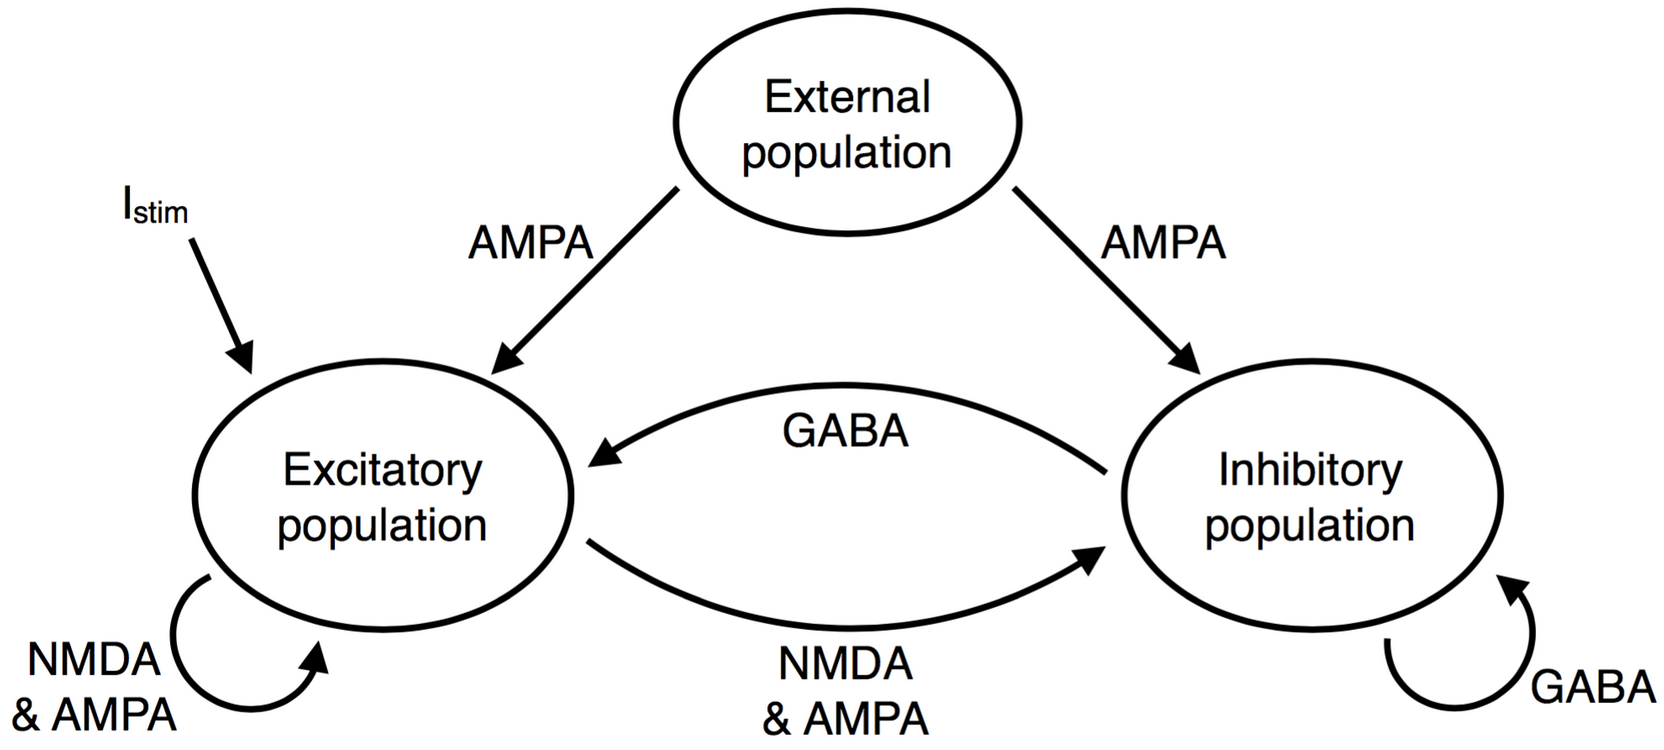

Please refer to [Figure 18.4](https://neuronaldynamics.epfl.ch/online/Ch18.S1.html#Ch18.F4) in chapter 18.1 in the Neuronal Dynamics book to see how the excitatory population is spatially arranged on a ring and has a particular connectivity profile. Within the implementation below, each excitatory neuron receives unstructured input from all inhibitory neurons and structured input from all excitatory neurons.
The inhibitory neurons receive unstructured inputs from all excitatory and inhibitory neurons.

* Please familiarize yourself with the source code below (It is not necessary to understand how the neural network simulator package Brian2 implements the Integrate and Fire neurons).

In [3]:
# @title source code

def simulate_wm(
        N_excitatory=1024, N_inhibitory=256,
        N_extern_poisson=1000, poisson_firing_rate=1.4 * b2.Hz, weight_scaling_factor=2.,
        sigma_weight_profile=20., Jpos_excit2excit=1.6,
        stimulus_center_deg=180, stimulus_width_deg=40, stimulus_strength=0.07 * b2.namp,
        t_stimulus_start=0 * b2.ms, t_stimulus_duration=0 * b2.ms,
        distractor_center_deg=90, distractor_width_deg=40, distractor_strength=0.0 * b2.namp,
        t_distractor_start=0 * b2.ms, t_distractor_duration=0 * b2.ms,
        G_inhib2inhib=1.024 * b2.nS,
        G_inhib2excit=1.336 * b2.nS,
        G_excit2excit=0.381 * b2.nS,
        G_excit2inhib=0.292 * b2.nS,
        monitored_subset_size=1024, sim_time=800. * b2.ms):
    """
    Args:
        N_excitatory (int): Size of the excitatory population
        N_inhibitory (int): Size of the inhibitory population
        weight_scaling_factor (float): weight prefactor. When increasing the size of the populations,
            the synaptic weights have to be decreased. Using the default values, we have
            N_excitatory*weight_scaling_factor = 2048 and N_inhibitory*weight_scaling_factor=512
        N_extern_poisson (int): Size of the external input population (Poisson input)
        poisson_firing_rate (Quantity): Firing rate of the external population
        sigma_weight_profile (float): standard deviation of the gaussian input profile in
            the excitatory population.
        Jpos_excit2excit (float): Strength of the recurrent input within the excitatory population.
            Jneg_excit2excit is computed from sigma_weight_profile, Jpos_excit2excit and the normalization
            condition.
        stimulus_center_deg (float): Center of the stimulus in [0, 360]
        stimulus_width_deg (float): width of the stimulus. All neurons in
            stimulus_center_deg +\\- (stimulus_width_deg/2) receive the same input current
        stimulus_strength (Quantity): Input current to the neurons at stimulus_center_deg +\\- (stimulus_width_deg/2)
        t_stimulus_start (Quantity): time when the input stimulus is turned on
        t_stimulus_duration (Quantity): duration of the stimulus.
        distractor_center_deg (float): Center of the distractor in [0, 360]
        distractor_width_deg (float): width of the distractor. All neurons in
            distractor_center_deg +\\- (distractor_width_deg/2) receive the same input current
            distractor_strength (Quantity): Input current to the neurons at
            distractor_center_deg +\\- (distractor_width_deg/2)
        t_distractor_start (Quantity): time when the distractor is turned on
        t_distractor_duration (Quantity): duration of the distractor.
        G_inhib2inhib (Quantity): projections from inhibitory to inhibitory population (later
            rescaled by weight_scaling_factor)
        G_inhib2excit (Quantity): projections from inhibitory to excitatory population (later
            rescaled by weight_scaling_factor)
        G_excit2excit (Quantity): projections from excitatory to excitatory population (later
            rescaled by weight_scaling_factor)
        G_excit2inhib (Quantity): projections from excitatory to inhibitory population (later
            rescaled by weight_scaling_factor)
        monitored_subset_size (int): nr of neurons for which a Spike- and Voltage monitor
            is registered.
        sim_time (Quantity): simulation time

    Returns:

       results (tuple):
       rate_monitor_excit (Brian2 PopulationRateMonitor for the excitatory population),
        spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
        rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
        weight_profile_45 (The weights profile for the neuron with preferred direction = 45deg).
    """
    # specify the excitatory pyramidal cells:
    Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
    G_leak_excit = 25.0 * b2.nS  # leak conductance
    E_leak_excit = -70.0 * b2.mV  # reversal potential
    v_firing_threshold_excit = -50.0 * b2.mV  # spike condition
    v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
    t_abs_refract_excit = 2.0 * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
    Cm_inhib = 0.2 * b2.nF
    G_leak_inhib = 20.0 * b2.nS
    E_leak_inhib = -70.0 * b2.mV
    v_firing_threshold_inhib = -50.0 * b2.mV
    v_reset_inhib = -60.0 * b2.mV
    t_abs_refract_inhib = 1.0 * b2.ms

    # specify the AMPA synapses
    E_AMPA = 0.0 * b2.mV
    tau_AMPA = .9 * 2.0 * b2.ms

    # specify the GABA synapses
    E_GABA = -70.0 * b2.mV
    tau_GABA = 10.0 * b2.ms

    # specify the NMDA synapses
    E_NMDA = 0.0 * b2.mV
    tau_NMDA_s = .65 * 100.0 * b2.ms  # orig: 100
    tau_NMDA_x = .94 * 2.0 * b2.ms
    alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
    G_extern2inhib = 2.38 * b2.nS
    G_extern2excit = 3.1 * b2.nS

    # projectsions from the inhibitory populations
    G_inhib2inhib *= weight_scaling_factor
    G_inhib2excit *= weight_scaling_factor

    # projections from the excitatory population
    G_excit2excit *= weight_scaling_factor
    G_excit2inhib *= weight_scaling_factor  #TODO : verify this scaling

    # compute the simulus index
    stim_center_idx = int(round(N_excitatory / 360. * stimulus_center_deg))
    stim_width_idx = int(round(N_excitatory / 360. * stimulus_width_deg / 2))
    stim_target_idx = [idx % N_excitatory
                       for idx in range(stim_center_idx - stim_width_idx, stim_center_idx + stim_width_idx + 1)]
    # compute the distractor index
    distr_center_idx = int(round(N_excitatory / 360. * distractor_center_deg))
    distr_width_idx = int(round(N_excitatory / 360. * distractor_width_deg / 2))
    distr_target_idx = [idx % N_excitatory for idx in range(distr_center_idx - distr_width_idx,
                                                            distr_center_idx + distr_width_idx + 1)]

    # precompute the weight profile for the recurrent population
    tmp = math.sqrt(2. * math.pi) * sigma_weight_profile * erf(180. / math.sqrt(2.) / sigma_weight_profile) / 360.
    Jneg_excit2excit = (1. - Jpos_excit2excit * tmp) / (1. - tmp)
    presyn_weight_kernel = \
        [(Jneg_excit2excit +
          (Jpos_excit2excit - Jneg_excit2excit) *
          math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2))
         for j in range(N_excitatory)]

    fft_presyn_weight_kernel = rfft(presyn_weight_kernel)
    weight_profile_45 = deque(presyn_weight_kernel)
    rot_dist = int(round(len(weight_profile_45) / 8))
    weight_profile_45.rotate(rot_dist)

    # define the inhibitory population
    inhib_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_inhib * (v-E_leak_inhib)
        - G_extern2inhib * s_AMPA * (v-E_AMPA)
        - G_inhib2inhib * s_GABA * (v-E_GABA)
        - G_excit2inhib * s_NMDA_total  * (v-E_NMDA)/(1.0+1.0*exp(-0.062*1e3*v/volt)/3.57)
        )/Cm_inhib : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
    """

    inhib_pop = NeuronGroup(
        N_inhibitory, model=inhib_lif_dynamics,
        threshold="v>v_firing_threshold_inhib", reset="v=v_reset_inhib", refractory=t_abs_refract_inhib,
        method="rk2")
    
    # initialize with random voltages:
    inhib_pop.v = np.random.uniform(v_reset_inhib / b2.mV, high=v_firing_threshold_inhib / b2.mV,
                                       size=N_inhibitory) * b2.mV
    # set the connections: inhib2inhib
    syn_inhib2inhib = Synapses(inhib_pop, target=inhib_pop, on_pre="s_GABA += 1.0", delay=0.0 * b2.ms)
    syn_inhib2inhib.connect(condition="i!=j", p=1.0)
    # set the connections: extern2inhib
    input_ext2inhib = PoissonInput(target=inhib_pop, target_var="s_AMPA",
                                   N=N_extern_poisson, rate=poisson_firing_rate, weight=1.0)

    # specify the excitatory population:
    excit_lif_dynamics = """
        I_stim : amp
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_excit * (v-E_leak_excit)
        - G_extern2excit * s_AMPA * (v-E_AMPA)
        - G_inhib2excit * s_GABA * (v-E_GABA)
        - G_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*1e3*v/volt)/3.57)
        + I_stim
        )/Cm_excit : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
        ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
        dx/dt = -x/tau_NMDA_x : 1
    """

    excit_pop = NeuronGroup(N_excitatory, model=excit_lif_dynamics,
                            threshold="v>v_firing_threshold_excit", reset="v=v_reset_excit; x+=1.0",
                            refractory=t_abs_refract_excit, method="rk2")
    # initialize with random voltages:
    excit_pop.v = np.random.uniform(v_reset_excit / b2.mV, high=v_firing_threshold_excit / b2.mV,
                                       size=N_excitatory) * b2.mV
    excit_pop.I_stim = 0. * b2.namp
    # set the connections: extern2excit
    input_ext2excit = PoissonInput(target=excit_pop, target_var="s_AMPA",
                                   N=N_extern_poisson, rate=poisson_firing_rate, weight=1.0)

    # set the connections: inhibitory to excitatory
    syn_inhib2excit = Synapses(inhib_pop, target=excit_pop, on_pre="s_GABA += 1.0")
    syn_inhib2excit.connect(p=1.0)

    # set the connections: excitatory to inhibitory NMDA connections
    syn_excit2inhib = Synapses(excit_pop, inhib_pop,
                               model="s_NMDA_total_post = s_NMDA_pre : 1 (summed)", method="rk2")
    syn_excit2inhib.connect(p=1.0)

    # set the STRUCTURED recurrent input. use a network_operation
    @network_operation()
    def update_nmda_sum():
        fft_s_NMDA = rfft(excit_pop.s_NMDA)
        fft_s_NMDA_total = np.multiply(fft_presyn_weight_kernel, fft_s_NMDA)
        s_NMDA_tot = irfft(fft_s_NMDA_total)
        excit_pop.s_NMDA_total_ = s_NMDA_tot

    @network_operation(dt=1 * b2.ms)
    def stimulate_network(t):
        if t >= t_stimulus_start and t < (t_stimulus_start+t_stimulus_duration):
            excit_pop.I_stim[stim_target_idx] = stimulus_strength
        else:
            excit_pop.I_stim = 0. * b2.namp
        # add distractor
        if t >= t_distractor_start and t < (t_distractor_start+t_distractor_duration):
            excit_pop.I_stim[distr_target_idx] = distractor_strength

    def get_monitors(pop, nr_monitored, N):
        nr_monitored = min(nr_monitored, (N))
        idx_monitored_neurons = \
            [int(math.ceil(k))
             for k in np.linspace(0, N - 1, nr_monitored + 2)][1:-1] 
        rate_monitor = PopulationRateMonitor(pop)
        spike_monitor = SpikeMonitor(pop, record=idx_monitored_neurons)
        voltage_monitor = StateMonitor(pop, "v", record=idx_monitored_neurons)
        return rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons

    # collect data of a subset of neurons:
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib = \
        get_monitors(inhib_pop, monitored_subset_size, N_inhibitory)

    rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit = \
        get_monitors(excit_pop, monitored_subset_size, N_excitatory)

    b2.run(sim_time)
    return \
        rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
        rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
        weight_profile_45


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
clang-14: error: the clang compiler does not support '-march=native'
In file included from /Users/willardwashingtonford/Library/Caches/cython/brian_extensions/_cython_magic_93218ebe27297f3e9f1cb1f5d4030f24.cpp:36:
In file included from /Users/willardwashingtonford/mambaforge/envs/BIPN164/include/python3.11/Python.h:23:
/Users/willardwashingtonford/mambaforge/envs/BIPN164/bin/../include/c++/v1/stdlib.h:150:34: error: unknown type name 'ldiv_t'
inline _LIBCPP_INLINE_VISIBILITY ldiv_t div(long __x, long __y) _NOEXCEPT {
                                 ^
/Users/willardwashingtonford/mambaforge/envs/BIPN164/bin/../include/c++/v1/stdlib.h:151:12: error: no member named 'ldiv' in the global namespace
  return ::ldiv(__x, __y);
         ~~^
/Users/willardwashingtonford/mambaforge/envs/BIPN164/bin/../include/c++/v1/stdlib.h:154:34: error: unknown type name 'lldiv_t'
inline _LIBCPP_INLINE_VISIBI

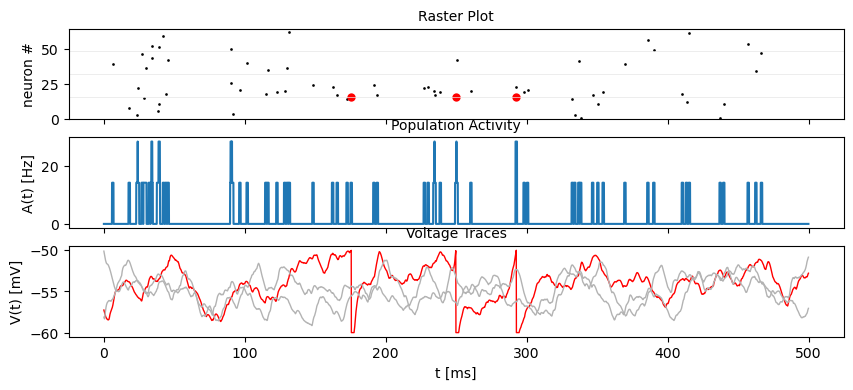

In [4]:
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(N_excitatory=64, 
                  N_inhibitory=16, 
                  weight_scaling_factor=8., 
                  sim_time=500. * b2.ms,
                  stimulus_center_deg=120, 
                  t_stimulus_start=100 * b2.ms, 
                  t_stimulus_duration=200 * b2.ms,
                  stimulus_strength=.07 * b2.namp)
    
plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

The plot_network_activity function creates a figure with 3 plots. The first is a raster plot of your neural population. Randomly, the spike trains of 3 random neurons are highlighted and their average voltage over time is plotted in the lowest plot. The middle plot shows the average population activity over time.

### 1a Please run another simulation with the following parameters:
```
N_excitatory=64
N_inhibitory=16
sim_time=800. * b2.ms
poisson_firing_rate=1.3 * b2.Hz
sigma_weight_profile=20.
Jpos_excit2excit=1.6
```

### 1b
* Change the firing rate of the external population to 2.2Hz

  What do you observe?
  
### 1c
* Run the simulation a few times with the firing rate of the external population at 2.2Hz

* Describe your observations in terms of the mean firing rate.


#### 1C Answer:
The mean firing rate, given by the second plot, seems to be pretty consistent in all of the runs I completed with the external population firing rate of 2.2Hz. It seems to be about 25, maybe 30 each time. Occasianlly we see a much higher average firing rate of about 50. We also see a significantly higher average firing rate than when the external firing rate is set to 1.3.

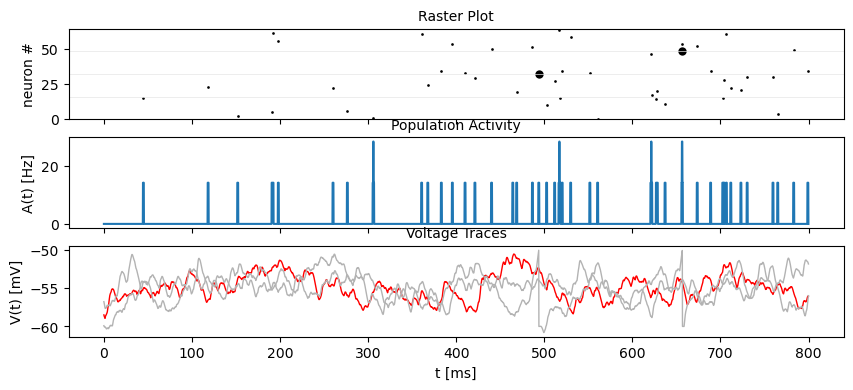

In [15]:
# 1a
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64,
                    N_inhibitory=16,
                    sim_time=800. * b2.ms,
                    poisson_firing_rate=1.3 * b2.Hz,
                    sigma_weight_profile=20.,
                    Jpos_excit2excit=1.6)





plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

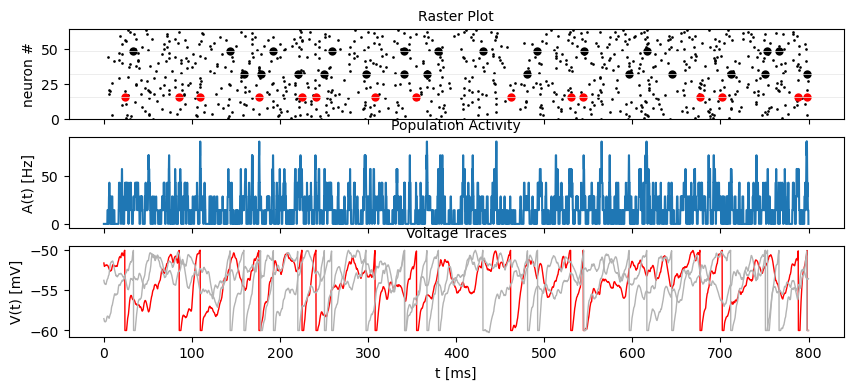

In [14]:
# 1b
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64,
                    N_inhibitory=16,
                    sim_time=800. * b2.ms,
                    poisson_firing_rate=2.2 * b2.Hz,
                    sigma_weight_profile=20.,
                    Jpos_excit2excit=1.6,
                    )





plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

## Exercise 1.1 - Analyzing the weight profile
The function simulate_wm() takes two parameters to define the weight profile: `sigma_weight_profile` and `Jpos_excit2excit`. After the simulation you can access the return value `weight_profile_45`. This array contains the synaptic weights between the one postsynaptic neuron whose preferred direction is 45 degrees and all other (presynaptic) neurons. Our choice of 45 degrees is arbitrary, the profile for other neurons are shifted versions of this one.

* 1.1a Use the same parameters as in exercise 1.1 again, and additionally plot the weight profile.  

  Increase `Jpos_excit2excit`. 
  
  How does the weight profile change (look at short and long ranges)?
* 1.1b Simulate with `Jpos_excit2excit = 2.3`. 

  What do you observe?

* 1.1c How does the weight profile change with the parameter `sigma_weight_profile`? How does the bump change with this parameter?


### 1.1a Answer:
As I increase the Jpos_excit2excit parameter the weight profile retains a static shape. The peak increases dramatically locally but globally, the weight to the distant neurons stays extremely low despite the increase.

### 1.1b Answer:
It looks like the peak of the weight is exactly 2.3 given the input Jpos_excit2excit = 2.3. It looks like this might actually be true for all values. Super cool.

### 1.1c Answer:
It looks like the shape of weight_profile_45 is always 1 complete sin wave with some level of transformation based on the value of sigma_weight_profile. At very low values it looks like a single very skinny peak with the rest of the weights showing very low values. With large values of sigma_weight_profile the weight_profile_45 looks far more like a sin wave, increasing at the end and decreasing slowly.

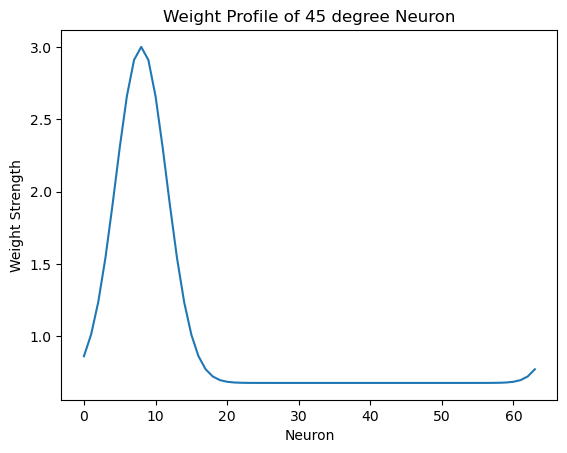

In [25]:
# 1.1a
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64,
                    N_inhibitory=16,
                    sim_time=800. * b2.ms,
                    poisson_firing_rate=1.3 * b2.Hz,
                    sigma_weight_profile=20.,
                    Jpos_excit2excit=3)

plt.plot(weight_profile)
plt.title("Weight Profile of 45 degree Neuron")
plt.xlabel("Neuron") # ??????
plt.ylabel("Weight Strength")
plt.show()


#plot_network_activity(rate_monitor_excit, 
#                      spike_monitor_excit, 
#                      voltage_monitor_excit,
#                      t_min=0. * b2.ms)
#plt.show()

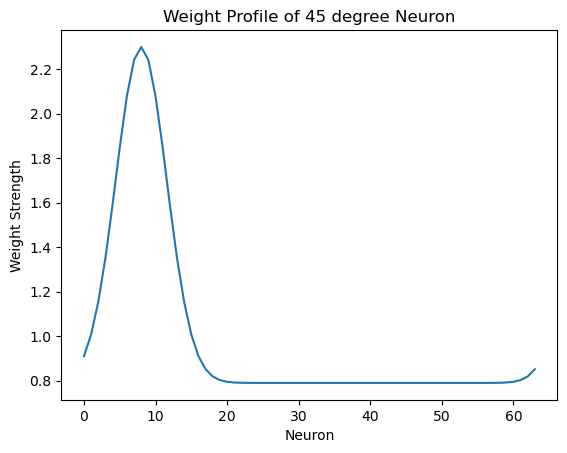

In [26]:
# 1.1b
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64,
                    N_inhibitory=16,
                    sim_time=800. * b2.ms,
                    poisson_firing_rate=1.3 * b2.Hz,
                    sigma_weight_profile=20.,
                    Jpos_excit2excit=2.3)

plt.plot(weight_profile)
plt.title("Weight Profile of 45 degree Neuron")
plt.xlabel("Neuron") # ??????
plt.ylabel("Weight Strength")
plt.show()


#plot_network_activity(rate_monitor_excit, 
#                      spike_monitor_excit, 
#                      voltage_monitor_excit,
#                      t_min=0. * b2.ms)
#plt.show()

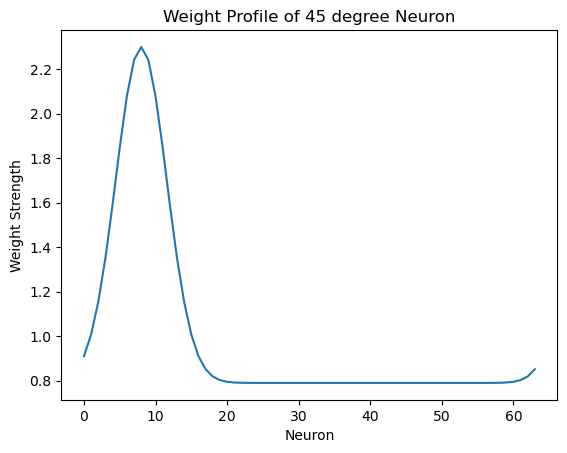

In [31]:
# 1.1c
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64,
                    N_inhibitory=16,
                    sim_time=800. * b2.ms,
                    poisson_firing_rate=1.3 * b2.Hz,
                    sigma_weight_profile=20.,
                    Jpos_excit2excit=2.3)

plt.plot(weight_profile)
plt.title("Weight Profile of 45 degree Neuron")
plt.xlabel("Neuron") # ??????
plt.ylabel("Weight Strength")
plt.show()


#plot_network_activity(rate_monitor_excit, 
#                      spike_monitor_excit, 
#                      voltage_monitor_excit,
#                      t_min=0. * b2.ms)
#plt.show()

# Exercise 1.2 - Structured external inputs
We now apply a stimulus to a subset of the excitatory population. The network has the property of integrating inputs over time and keep a memory of the input stimulus. Using the following code, you can run a simulation with a weak input stimulus.

Run the stimulation with the following parameters. Then answer the following questions qualitatively (by eye, from the raster plot)

```
N_excitatory=64 
N_inhibitory=16
stimulus_center_deg=120
stimulus_width_deg=30
stimulus_strength=.06 * b2.namp
t_stimulus_start=100 * b2.ms
t_stimulus_duration=200 * b2.ms
sim_time=500. * b2.ms
```

### 1.2a
* At which time can you identify a change in the population activity? How does that compare to the time when the stimulus is applied?
    
### 1.2b
* What is the population activity at the end of the simulation?

### 1.2c
* For the time point $t=400ms$, sketch the firing rate across the population (neuron index on the x-axis, per-neuron firing rate on the y-axis). (A simple MS Paint or online equivalent sketch is fine.)

### 1.2d 
* Increase the stimulus strength to $0.5nA$. 
* What happens when the stimulus stops?

### 1.2e
* Increase the stimulus width to 60 degrees:
(`stimulus_width_deg=60, stimulus_strength=0.1 * b2.namp, stimulus_center_deg = 120`). How does the bump shape change?


### 1.2a Answer:
We see a the largest bulkiest population spike in activity at about 120ms, this is pretty short after the stimulus start time of 100ms so we can strongly see that thesse are correlated with each other.

### 1.2b Answer:
Towards the end of the simulation the population activity becomes more sporadic but not quite trailing off. This makse some sense because the excititory neurons activate themselves throughout the time period. For some reason at the very end though, we also see an increase in activity across many neurons that are not very similar to each other.

### 1.2c Answer:

### 1.2d Answer:
After the stimulus stops, we see a brief period of almost no activity before the neurons continue to spike sporadically. This is likely explained by the time scale variables associated with the excititory neurons which cause a small delay.

Even more interesting though, we see many neurons all right near each other spiking over the course of the input, and then after the input ends we see the activity 'difuse' through the other neurons before becoming more sporadic.

### 1.2e Answer:
We see a similar cluster of neurons spiking over a period of input activity. But the cluster is not as dense and we can see a wider number of neruons activating sporadically over that period. A wider spread of activity across the neurons.

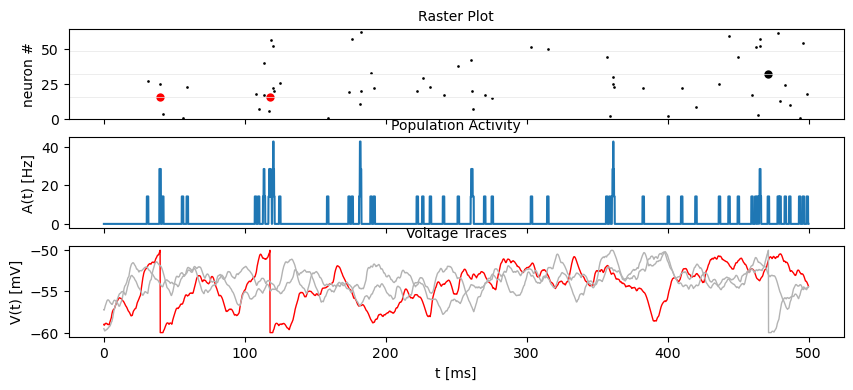

In [32]:
# 1.2a
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64, 
                    N_inhibitory=16,
                    stimulus_center_deg=120,
                    stimulus_width_deg=30,
                    stimulus_strength=.06 * b2.namp,
                    t_stimulus_start=100 * b2.ms,
                    t_stimulus_duration=200 * b2.ms,
                    sim_time=500. * b2.ms)

plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

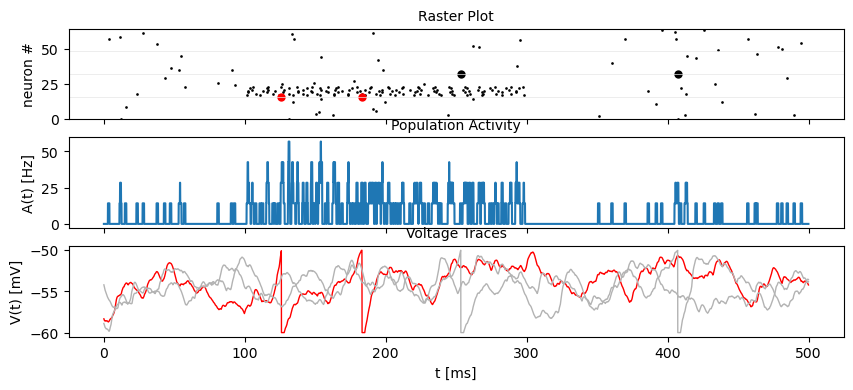

In [33]:
# 1.2d
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64, 
                    N_inhibitory=16,
                    stimulus_center_deg=120,
                    stimulus_width_deg=30,
                    stimulus_strength=.5 * b2.namp,
                    t_stimulus_start=100 * b2.ms,
                    t_stimulus_duration=200 * b2.ms,
                    sim_time=500. * b2.ms)

plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

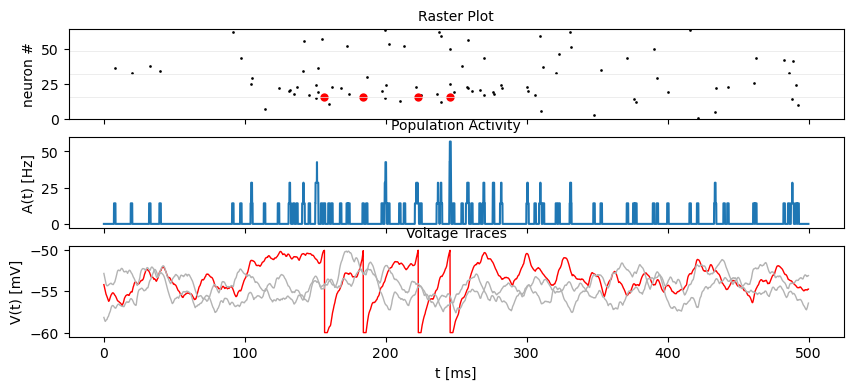

In [34]:
# 1.2e
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_excitatory=64, 
                    N_inhibitory=16,
                    stimulus_center_deg=120,
                    stimulus_width_deg=60,
                    stimulus_strength=.1 * b2.namp,
                    t_stimulus_start=100 * b2.ms,
                    t_stimulus_duration=200 * b2.ms,
                    sim_time=500. * b2.ms)


plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

# Exercise 1.3 The Inhibitory Population
Examine the role of the inhibitory population by setting its size to the minimal size `N_inhibitory = 1`. If we also deactivate the external input we can study the effect of the recurrent weights within the excitatory population:

Please use the following parameters for this exercise:
```
N_inhibitory = 1
stimulus_strength=0.65 * b2.namp
t_stimulus_start=5 * b2.ms
t_stimulus_duration=25 * b2.ms
sim_time=80. * b2.ms
```

### 1.3a 
* Before running the simulation: What do you expect to see?

* Run the simulation with the given parameters. Describe your observations.


### 1.3 Answer:
With only one inhibitory neuron and no excititory neurons, I would expect this network to shut itself down very quickly after activation and then have no activity.

My initial assumption was correct, however the length of the input causes this activity to spike up and then drop as the neuron inhibits itself over and over again over the period of activation. We mostly see in the raster plot that every neuron is just inhibited over the entire period.

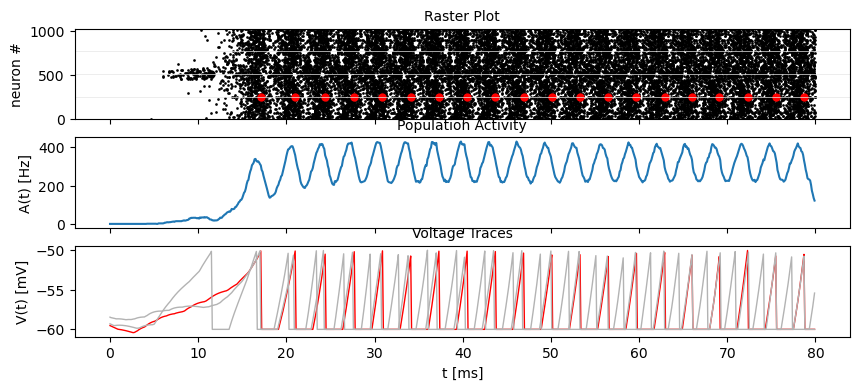

In [35]:
# 1.3a
# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(  N_inhibitory = 1,
                    stimulus_strength=0.65 * b2.namp,
                    t_stimulus_start=5 * b2.ms,
                    t_stimulus_duration=25 * b2.ms,
                    sim_time=80. * b2.ms)


plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

### 1.3b
* Plot the raster, population activity and voltage traces for the inhibitory population, like you did previously for the excitatory population.

* What is the role of the inhibitory population?



### 1.3b Answer:

In this case we can see that the inhibitory population simply inactivates itself. The population activity and raster plot show the inhibitory neurons not spiking which is what we would expect.

The role of inhibitory population is to restrict the activity, so with a ratio of mostly inhibitory neurons we can see that the activity is severely limited.

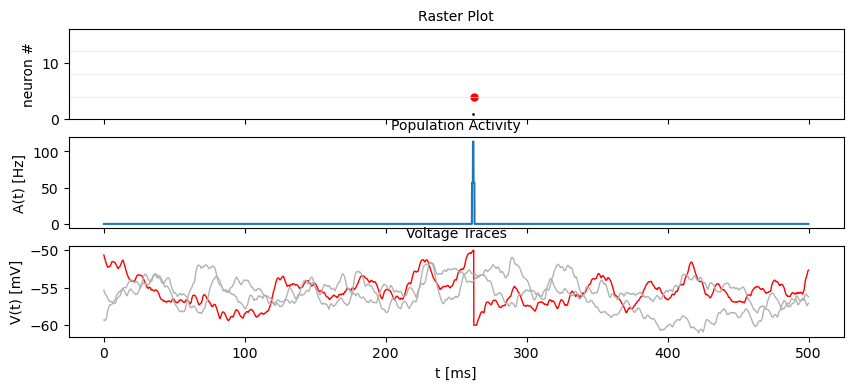

In [41]:
# Plot the raster, population activity and voltage traces for the inhibitory population
# 1.3b

# This is a judgement call but I'm just going to swap the ratios of excitatory and inhibitory neurons.

# This simple script simulates a simple ring attractor network.

# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

b2.defaultclock.dt = 0.1 * b2.ms

rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit,\
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib,\
    weight_profile\
    = simulate_wm(N_excitatory=16, 
                  N_inhibitory=64, 
                  weight_scaling_factor=8., 
                  sim_time=500. * b2.ms,
                  stimulus_center_deg=120, 
                  t_stimulus_start=100 * b2.ms, 
                  t_stimulus_duration=200 * b2.ms,
                  stimulus_strength=.07 * b2.namp)
    
plot_network_activity(rate_monitor_excit, 
                      spike_monitor_excit, 
                      voltage_monitor_excit,
                      t_min=0. * b2.ms)
plt.show()

# Exercise 2 - Perceptual Decision making
For the second part of this assignment, we will be study a network of competing populations of spiking neurons. This particular network was proposed by [Wong and Wang](https://doi.org/10.1523/JNEUROSCI.3733-05.2006). This network is also described in [chapter 16 in the Neuronal Dynamics book](http://neuronaldynamics.epfl.ch/online/Ch16.html).

Note: Some of the parameters were changed to see interesting results with fewer neurons per population needed.




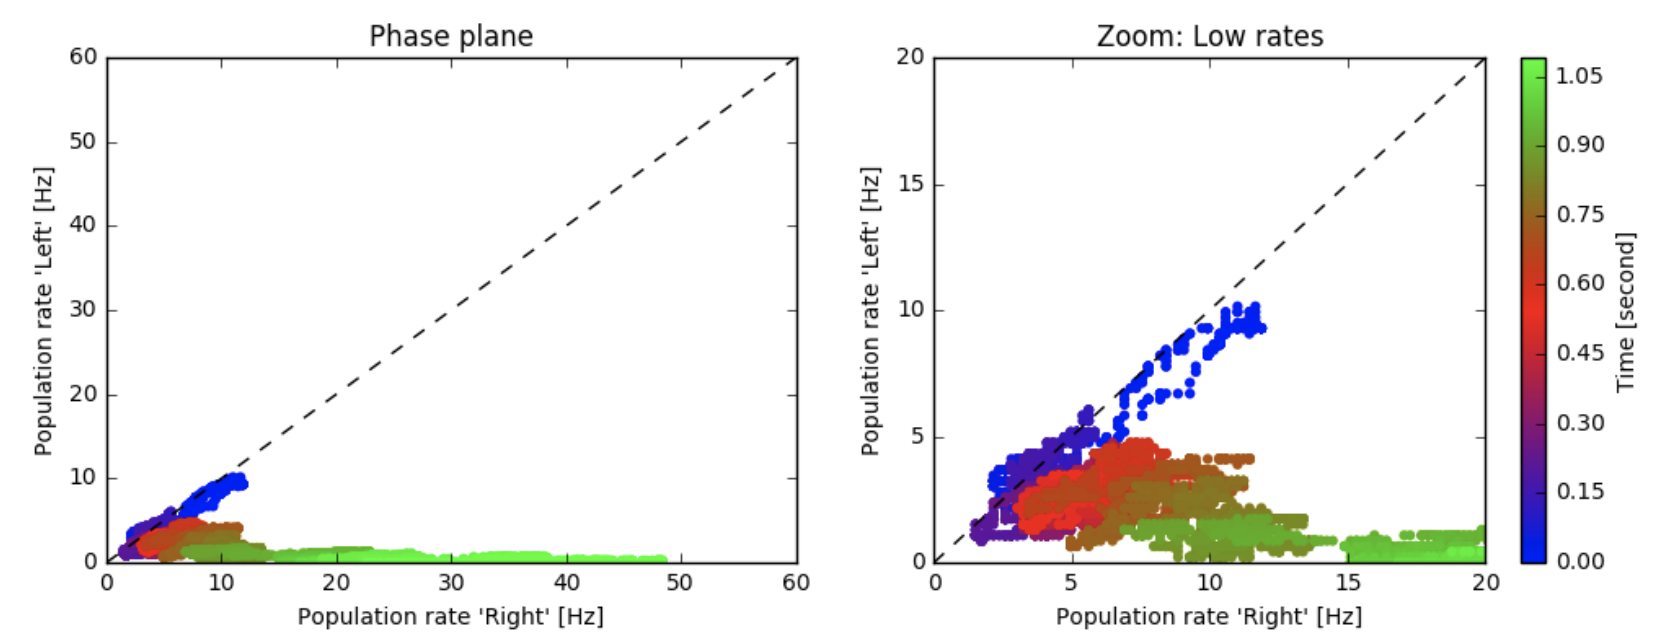

The figure above depicts the decision space, with each point representing the firing rates of the two competing populations ("Left"and "Right") at a given point in time (averaged over a short time window).

### The Network Structure
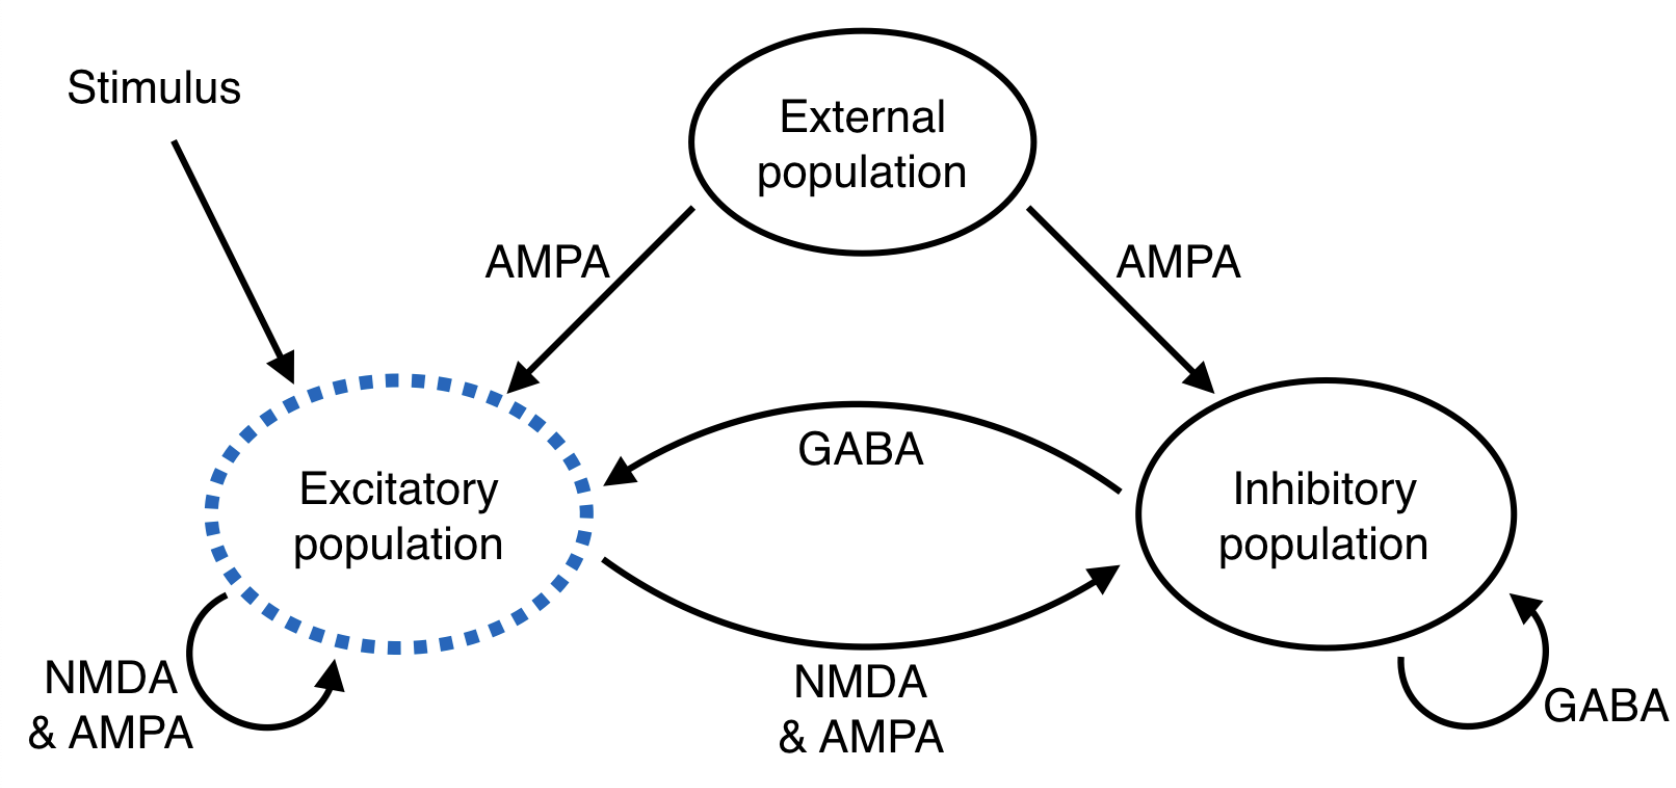

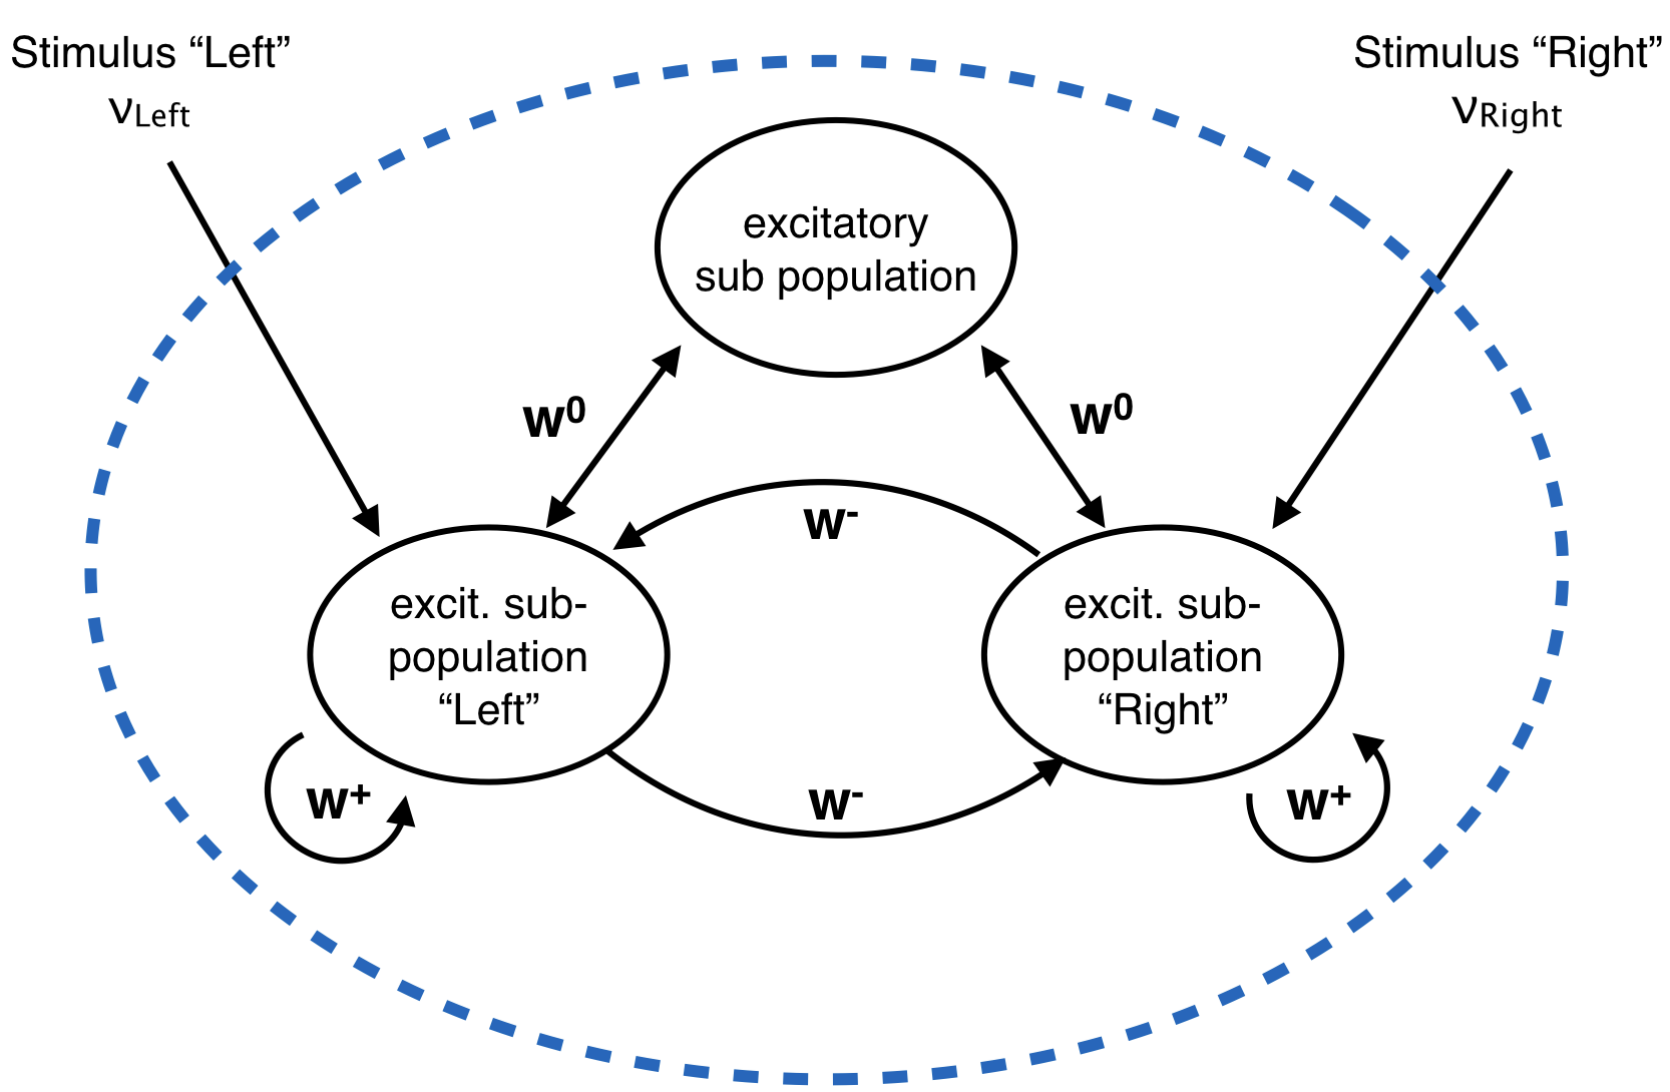

As you can see in the plots above the excitatory population is split into three subpopulations. The "Left" and "Right" populations have weak projections to one another ($w^- < w^0$) and strong recurrent weights ($w^+ > w^0$). All neurons within the excitatoy population receive an external poisson input with some rate $v_{left}$ and $v_{right}$ for the Left and Right subpopulations respectively.

The network above is slightly more complicated than it needs to be as it contains an external population and the excitatory sub-population. However, those populations are just there for the possibility of adding random noise into the network and are not important for the following exercises.

# Exercise 2.0
* Familiarize yourself with the source code of the model below.


In [42]:
# @title source code
b2.defaultclock.dt = 0.10 * b2.ms

def sim_decision_making_network(N_Excit=384, N_Inhib=96, weight_scaling_factor=5.33,
                                t_stimulus_start=100 * b2.ms, t_stimulus_duration=9999 * b2.ms, coherence_level=0.,
                                stimulus_update_interval=30 * b2.ms, mu0_mean_stimulus_Hz=160.,
                                stimulus_std_Hz=20.,
                                N_extern=1000, firing_rate_extern=9.8 * b2.Hz,
                                w_pos=1.90, f_Subpop_size=0.25,  # .15 in publication [1]
                                max_sim_time=1000. * b2.ms, stop_condition_rate=None,
                                monitored_subset_size=512):
    """

    Args:
        N_Excit (int): total number of neurons in the excitatory population
        N_Inhib (int): nr of neurons in the inhibitory populations
        weight_scaling_factor: When increasing the number of neurons by 2, the weights should be scaled down by 1/2
        t_stimulus_start (Quantity): time when the stimulation starts
        t_stimulus_duration (Quantity): duration of the stimulation
        coherence_level (int): coherence of the stimulus.
            Difference in mean between the PoissonGroups "left" stimulus and "right" stimulus
        stimulus_update_interval (Quantity): the mean of the stimulating PoissonGroups is
            re-sampled at this interval
        mu0_mean_stimulus_Hz (float): maximum mean firing rate of the stimulus if c=+1 or c=-1. Each neuron
            in the populations "Left" and "Right" receives an independent poisson input.
        stimulus_std_Hz (float): std deviation of the stimulating PoissonGroups.
        N_extern (int): nr of neurons in the stimulus independent poisson background population
        firing_rate_extern (int): firing rate of the stimulus independent poisson background population
        w_pos (float): Scaling (strengthening) of the recurrent weights within the
            subpopulations "Left" and "Right"
        f_Subpop_size (float): fraction of the neurons in the subpopulations "Left" and "Right".
            #left = #right = int(f_Subpop_size*N_Excit).
        max_sim_time (Quantity): simulated time.
        stop_condition_rate (Quantity): An optional stopping criteria: If not None, the simulation stops if the
            firing rate of either subpopulation "Left" or "Right" is above stop_condition_rate.
        monitored_subset_size (int): max nr of neurons for which a state monitor is registered.

    Returns:

        A dictionary with the following keys (strings):
        "rate_monitor_A", "spike_monitor_A", "voltage_monitor_A", "idx_monitored_neurons_A", "rate_monitor_B",
         "spike_monitor_B", "voltage_monitor_B", "idx_monitored_neurons_B", "rate_monitor_Z", "spike_monitor_Z",
         "voltage_monitor_Z", "idx_monitored_neurons_Z", "rate_monitor_inhib", "spike_monitor_inhib",
         "voltage_monitor_inhib", "idx_monitored_neurons_inhib"

    """

    print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
    t_stimulus_end = t_stimulus_start + t_stimulus_duration

    N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
    N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
    N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

    Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
    G_leak_excit = 25.0 * b2.nS  # leak conductance
    E_leak_excit = -70.0 * b2.mV  # reversal potential
    v_spike_thr_excit = -50.0 * b2.mV  # spike condition
    v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
    t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

    # specify the inhibitory interneurons:
    Cm_inhib = 0.2 * b2.nF
    G_leak_inhib = 20.0 * b2.nS
    E_leak_inhib = -70.0 * b2.mV
    v_spike_thr_inhib = -50.0 * b2.mV
    v_reset_inhib = -60.0 * b2.mV
    t_abs_refract_inhib = 1.0 * b2.ms

    # specify the AMPA synapses
    E_AMPA = 0.0 * b2.mV
    tau_AMPA = 2.5 * b2.ms

    # specify the GABA synapses
    E_GABA = -70.0 * b2.mV
    tau_GABA = 5.0 * b2.ms

    # specify the NMDA synapses
    E_NMDA = 0.0 * b2.mV
    tau_NMDA_s = 100.0 * b2.ms
    tau_NMDA_x = 2. * b2.ms
    alpha_NMDA = 0.5 * b2.kHz

    # projections from the external population
    g_AMPA_extern2inhib = 1.62 * b2.nS
    g_AMPA_extern2excit = 2.1 * b2.nS

    # projectsions from the inhibitory populations
    g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
    g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

    # projections from the excitatory population
    g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
    g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
    g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
    g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

    # weights and "adjusted" weights.
    w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
    # We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
    w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
    w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
    # other weights are 1
    # print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))

    # Define the inhibitory population
    # dynamics:
    inhib_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_inhib * (v-E_leak_inhib)
        - g_AMPA_excit2inhib * s_AMPA * (v-E_AMPA)
        - g_GABA_inhib2inhib * s_GABA * (v-E_GABA)
        - g_NMDA_excit2inhib * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
        )/Cm_inhib : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
    """

    inhib_pop = NeuronGroup(
        N_Inhib, model=inhib_lif_dynamics,
        threshold="v>v_spike_thr_inhib", reset="v=v_reset_inhib", refractory=t_abs_refract_inhib,
        method="rk2")
    # initialize with random voltages:
    inhib_pop.v = rnd.uniform(v_spike_thr_inhib / b2.mV - 4., high=v_spike_thr_inhib / b2.mV - 1., size=N_Inhib) * b2.mV

    # Specify the excitatory population:
    # dynamics:
    excit_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_excit * (v-E_leak_excit)
        - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
        - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
        - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
        )/Cm_excit : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
        ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
        dx/dt = -x/tau_NMDA_x : 1
    """

    # define the three excitatory subpopulations.
    # A: subpop receiving stimulus A
    excit_pop_A = NeuronGroup(N_Group_A, model=excit_lif_dynamics,
                              threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                              refractory=t_abs_refract_excit, method="rk2")
    excit_pop_A.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_A.N) * b2.mV

    # B: subpop receiving stimulus B
    excit_pop_B = NeuronGroup(N_Group_B, model=excit_lif_dynamics, threshold="v>v_spike_thr_excit",
                              reset="v=v_reset_excit", refractory=t_abs_refract_excit, method="rk2")
    excit_pop_B.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_B.N) * b2.mV
    # Z: non-sensitive
    excit_pop_Z = NeuronGroup(N_Group_Z, model=excit_lif_dynamics,
                              threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                              refractory=t_abs_refract_excit, method="rk2")
    excit_pop_Z.v = rnd.uniform(v_reset_excit / b2.mV, high=v_spike_thr_excit / b2.mV - 1., size=excit_pop_Z.N) * b2.mV

    # now define the connections:
    # projections FROM EXTERNAL POISSON GROUP: ####################################################
    poisson2Inhib = PoissonInput(target=inhib_pop, target_var="s_AMPA",
                                 N=N_extern, rate=firing_rate_extern, weight=w_ext2inhib)
    poisson2A = PoissonInput(target=excit_pop_A, target_var="s_AMPA",
                             N=N_extern, rate=firing_rate_extern, weight=w_ext2excit)

    poisson2B = PoissonInput(target=excit_pop_B, target_var="s_AMPA",
                             N=N_extern, rate=firing_rate_extern, weight=w_ext2excit)
    poisson2Z = PoissonInput(target=excit_pop_Z, target_var="s_AMPA",
                             N=N_extern, rate=firing_rate_extern, weight=w_ext2excit)

    ###############################################################################################

    # GABA projections FROM INHIBITORY population: ################################################
    syn_inhib2inhib = Synapses(inhib_pop, target=inhib_pop, on_pre="s_GABA += 1.0", delay=0.5 * b2.ms)
    syn_inhib2inhib.connect(p=1.)
    syn_inhib2A = Synapses(inhib_pop, target=excit_pop_A, on_pre="s_GABA += 1.0", delay=0.5 * b2.ms)
    syn_inhib2A.connect(p=1.)
    syn_inhib2B = Synapses(inhib_pop, target=excit_pop_B, on_pre="s_GABA += 1.0", delay=0.5 * b2.ms)
    syn_inhib2B.connect(p=1.)
    syn_inhib2Z = Synapses(inhib_pop, target=excit_pop_Z, on_pre="s_GABA += 1.0", delay=0.5 * b2.ms)
    syn_inhib2Z.connect(p=1.)
    ###############################################################################################

    # AMPA projections FROM EXCITATORY A: #########################################################
    syn_AMPA_A2A = Synapses(excit_pop_A, target=excit_pop_A, on_pre="s_AMPA += w_pos", delay=0.5 * b2.ms)
    syn_AMPA_A2A.connect(p=1.)
    syn_AMPA_A2B = Synapses(excit_pop_A, target=excit_pop_B, on_pre="s_AMPA += w_neg", delay=0.5 * b2.ms)
    syn_AMPA_A2B.connect(p=1.)
    syn_AMPA_A2Z = Synapses(excit_pop_A, target=excit_pop_Z, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_A2Z.connect(p=1.)
    syn_AMPA_A2inhib = Synapses(excit_pop_A, target=inhib_pop, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_A2inhib.connect(p=1.)
    ###############################################################################################

    # AMPA projections FROM EXCITATORY B: #########################################################
    syn_AMPA_B2A = Synapses(excit_pop_B, target=excit_pop_A, on_pre="s_AMPA += w_neg", delay=0.5 * b2.ms)
    syn_AMPA_B2A.connect(p=1.)
    syn_AMPA_B2B = Synapses(excit_pop_B, target=excit_pop_B, on_pre="s_AMPA += w_pos", delay=0.5 * b2.ms)
    syn_AMPA_B2B.connect(p=1.)
    syn_AMPA_B2Z = Synapses(excit_pop_B, target=excit_pop_Z, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_B2Z.connect(p=1.)
    syn_AMPA_B2inhib = Synapses(excit_pop_B, target=inhib_pop, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_B2inhib.connect(p=1.)
    ###############################################################################################

    # AMPA projections FROM EXCITATORY Z: #########################################################
    syn_AMPA_Z2A = Synapses(excit_pop_Z, target=excit_pop_A, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_Z2A.connect(p=1.)
    syn_AMPA_Z2B = Synapses(excit_pop_Z, target=excit_pop_B, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_Z2B.connect(p=1.)
    syn_AMPA_Z2Z = Synapses(excit_pop_Z, target=excit_pop_Z, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_Z2Z.connect(p=1.)
    syn_AMPA_Z2inhib = Synapses(excit_pop_Z, target=inhib_pop, on_pre="s_AMPA += 1.0", delay=0.5 * b2.ms)
    syn_AMPA_Z2inhib.connect(p=1.)
    ###############################################################################################

    # NMDA projections FROM EXCITATORY to INHIB, A,B,Z
    @network_operation()
    def update_nmda_sum():
        sum_sNMDA_A = sum(excit_pop_A.s_NMDA)
        sum_sNMDA_B = sum(excit_pop_B.s_NMDA)
        sum_sNMDA_Z = sum(excit_pop_Z.s_NMDA)
        # note the _ at the end of s_NMDA_total_ disables unit checking
        inhib_pop.s_NMDA_total_ = (1.0 * sum_sNMDA_A + 1.0 * sum_sNMDA_B + 1.0 * sum_sNMDA_Z)
        excit_pop_A.s_NMDA_total_ = (w_pos * sum_sNMDA_A + w_neg * sum_sNMDA_B + w_neg * sum_sNMDA_Z)
        excit_pop_B.s_NMDA_total_ = (w_neg * sum_sNMDA_A + w_pos * sum_sNMDA_B + w_neg * sum_sNMDA_Z)
        excit_pop_Z.s_NMDA_total_ = (1.0 * sum_sNMDA_A + 1.0 * sum_sNMDA_B + 1.0 * sum_sNMDA_Z)

    # set a self-recurrent synapse to introduce a delay when updating the intermediate
    # gating variable x
    syn_x_A2A = Synapses(excit_pop_A, excit_pop_A, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_A2A.connect(j="i")
    syn_x_B2B = Synapses(excit_pop_B, excit_pop_B, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_B2B.connect(j="i")
    syn_x_Z2Z = Synapses(excit_pop_Z, excit_pop_Z, on_pre="x += 1.", delay=0.5 * b2.ms)
    syn_x_Z2Z.connect(j="i")
    ###############################################################################################

    # Define the stimulus: two PoissonInput with time time-dependent mean.
    poissonStimulus2A = PoissonGroup(N_Group_A, 0. * b2.Hz)
    syn_Stim2A = Synapses(poissonStimulus2A, excit_pop_A, on_pre="s_AMPA+=w_ext2excit")
    syn_Stim2A.connect(j="i")
    poissonStimulus2B = PoissonGroup(N_Group_B, 0. * b2.Hz)
    syn_Stim2B = Synapses(poissonStimulus2B, excit_pop_B, on_pre="s_AMPA+=w_ext2excit")
    syn_Stim2B.connect(j="i")

    @network_operation(dt=stimulus_update_interval)
    def update_poisson_stimulus(t):
        if t >= t_stimulus_start and t < t_stimulus_end:
            offset_A = mu0_mean_stimulus_Hz * (0.5 + 0.5 * coherence_level)
            offset_B = mu0_mean_stimulus_Hz * (0.5 - 0.5 * coherence_level)

            rate_A = np.random.normal(offset_A, stimulus_std_Hz)
            rate_A = (max(0, rate_A)) * b2.Hz  # avoid negative rate
            rate_B = np.random.normal(offset_B, stimulus_std_Hz)
            rate_B = (max(0, rate_B)) * b2.Hz

            poissonStimulus2A.rates = rate_A
            poissonStimulus2B.rates = rate_B
            # print("stim on. rate_A= {}, rate_B = {}".format(rate_A, rate_B))
        else:
            # print("stim off")
            poissonStimulus2A.rates = 0.
            poissonStimulus2B.rates = 0.

    ###############################################################################################

    def get_monitors(pop, monitored_subset_size):
        """
        Internal helper.
        Args:
            pop:
            monitored_subset_size:

        Returns:

        """
        monitored_subset_size = min(monitored_subset_size, pop.N)
        idx_monitored_neurons = sample(range(pop.N), monitored_subset_size)
        rate_monitor = PopulationRateMonitor(pop)
        # record parameter: record=idx_monitored_neurons is not supported???
        spike_monitor = SpikeMonitor(pop, record=idx_monitored_neurons)
        voltage_monitor = StateMonitor(pop, "v", record=idx_monitored_neurons)
        return rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons

    # collect data of a subset of neurons:
    rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib = \
        get_monitors(inhib_pop, monitored_subset_size)

    rate_monitor_A, spike_monitor_A, voltage_monitor_A, idx_monitored_neurons_A = \
        get_monitors(excit_pop_A, monitored_subset_size)

    rate_monitor_B, spike_monitor_B, voltage_monitor_B, idx_monitored_neurons_B = \
        get_monitors(excit_pop_B, monitored_subset_size)

    rate_monitor_Z, spike_monitor_Z, voltage_monitor_Z, idx_monitored_neurons_Z = \
        get_monitors(excit_pop_Z, monitored_subset_size)

    if stop_condition_rate is None:
        b2.run(max_sim_time)
    else:
        sim_sum = 0. * b2.ms
        sim_batch = 100. * b2.ms
        samples_in_batch = int(floor(sim_batch / b2.defaultclock.dt))
        avg_rate_in_batch = 0
        while (sim_sum < max_sim_time) and (avg_rate_in_batch < stop_condition_rate):
            b2.run(sim_batch)
            avg_A = np.mean(rate_monitor_A.rate[-samples_in_batch:])
            avg_B = np.mean(rate_monitor_B.rate[-samples_in_batch:])
            avg_rate_in_batch = max(avg_A, avg_B)
            sim_sum += sim_batch

    print("sim end: {}".format(time.ctime()))
    ret_vals = dict()

    ret_vals["rate_monitor_A"] = rate_monitor_A
    ret_vals["spike_monitor_A"] = spike_monitor_A
    ret_vals["voltage_monitor_A"] = voltage_monitor_A
    ret_vals["idx_monitored_neurons_A"] = idx_monitored_neurons_A

    ret_vals["rate_monitor_B"] = rate_monitor_B
    ret_vals["spike_monitor_B"] = spike_monitor_B
    ret_vals["voltage_monitor_B"] = voltage_monitor_B
    ret_vals["idx_monitored_neurons_B"] = idx_monitored_neurons_B

    ret_vals["rate_monitor_Z"] = rate_monitor_Z
    ret_vals["spike_monitor_Z"] = spike_monitor_Z
    ret_vals["voltage_monitor_Z"] = voltage_monitor_Z
    ret_vals["idx_monitored_neurons_Z"] = idx_monitored_neurons_Z

    ret_vals["rate_monitor_inhib"] = rate_monitor_inhib
    ret_vals["spike_monitor_inhib"] = spike_monitor_inhib
    ret_vals["voltage_monitor_inhib"] = voltage_monitor_inhib
    ret_vals["idx_monitored_neurons_inhib"] = idx_monitored_neurons_inhib

    return ret_vals



def run_multiple_simulations(
        f_get_decision_time, coherence_levels, nr_repetitions,
        max_sim_time=1200 * b2.ms, rate_threshold=25 * b2.Hz, avg_window_width=30 * b2.ms,
        N_excit=384, N_inhib=96, weight_scaling=5.33, w_pos=1.9, f_Subpop_size=0.25,
        t_stim_start=100 * b2.ms, t_stim_duration=99999 * b2.ms,
        mu0_mean_stim_Hz=160., stimulus_StdDev_Hz=20., stim_upd_interval=30 * b2.ms,
        N_extern=1000, firing_rate_extern=9.8 * b2.Hz
):
    """

    Args:
        f_get_decision_time (Function): a function that implements the decision criterion.
        coherence_levels (array): A list of coherence levels
        nr_repetitions (int): Number of repetitions (independent simulations).
        max_sim_time (Quantity): max simulation time.
        rate_threshold (Quantity): A firing rate threshold passed to f_get_decision_time.
        avg_window_width (Quantity): window size when smoothing the firing rates. Passed to f_get_decision_time.
        N_excit (int): total number of neurons in the excitatory population
        N_inhib (int): nr of neurons in the inhibitory populations
        weight_scaling (float): When increasing the number of neurons by 2, the weights should be scaled
            down by 1/2
        w_pos (float): Scaling (strengthening) of the recurrent weights within the
            subpopulations "Left" and "Right"
        f_Subpop_size (float): fraction of the neurons in the subpopulations "Left" and "Right".
            #left = #right = int(f_Subpop_size*N_Excit).
        t_stim_start (Quantity): Start of the stimulation
        t_stim_duration (Quantity): Duration of the stimulation
        mu0_mean_stim_Hz (float): maximum mean firing rate of the stimulus if c=+1 or c=-1
        stimulus_StdDev_Hz (float): std deviation of the stimulating PoissonGroups.
        stim_upd_interval (Quantity): the mean of the stimulating PoissonGroups is
            re-sampled at this interval
        N_extern=1000 (int): Size of the external PoissonGroup (unstructured input)
        firing_rate_extern (Quantity): Firing frequency of the external PoissonGroup

    Returns:

        results_tuple (array):
        Five values are returned. [1] time_to_A: A matrix of size
        [nr_of_c_levels x nr_of_repetitions], where for each entry the time stamp
        for decision A is recorded. If decision B was made, the entry is 0ms.
        [2] time_to_B (array): A matrix of size [nr_of_c_levels x nr_of_repetitions],
        where for each entry the time stamp for decision B is recorded.
        If decision A was made, the entry is 0ms. [3] count_A (int): Nr of times decision A is made.
        [4] count_B (int): Nr of times decision B is made.
        [5] count_No (int): Nr of times no decision is made within the simulation time.

    """

    nr_coherence = len(coherence_levels)
    count_A = np.zeros(nr_coherence, dtype=np.int8)
    count_B = np.zeros(nr_coherence, dtype=np.int8)
    count_No = np.zeros(nr_coherence, dtype=np.int8)

    time_to_A = np.zeros((nr_coherence, nr_repetitions))
    time_to_B = np.zeros((nr_coherence, nr_repetitions))

    for i_coherence in range(nr_coherence):
        c = coherence_levels[i_coherence]
        print("********************************************")
        print("coherence_level={}".format(c))
        for i_run in range(nr_repetitions):
            print("i_run={}".format(i_run))
            results = sim_decision_making_network(
                N_Excit=N_excit, N_Inhib=N_inhib, weight_scaling_factor=weight_scaling,
                w_pos=w_pos, f_Subpop_size=f_Subpop_size,
                t_stimulus_start=t_stim_start, t_stimulus_duration=t_stim_duration, coherence_level=c,
                max_sim_time=max_sim_time, stop_condition_rate=rate_threshold,
                mu0_mean_stimulus_Hz=mu0_mean_stim_Hz, stimulus_std_Hz=stimulus_StdDev_Hz,
                stimulus_update_interval=stim_upd_interval,
                N_extern=1000, firing_rate_extern=9.5 * b2.Hz,
            )
            t_A, t_B = f_get_decision_time(results["rate_monitor_A"],
                                           results["rate_monitor_B"],
                                           avg_window_width, rate_threshold)
            time_to_A[i_coherence, i_run] = t_A
            time_to_B[i_coherence, i_run] = t_B
            print("t_A={}, t_B={}".format(t_A, t_B))
            if (t_A > 0) and (t_B > 0.):
                print("no decision/error: f_get_decision_time returns > 0 for A and B ")
                count_No[i_coherence] += 1
            elif(t_A == 0) and (t_B == 0):
                print("no decision")
                count_No[i_coherence] += 1
            elif t_A > 0.:
                print("decision: A")
                count_A[i_coherence] += 1
            else:
                print("decision: B")
                count_B[i_coherence] += 1

    return time_to_A, time_to_B, count_A, count_B, count_No



# 2.1
* Extend the following code block to include plots for all four subpopulations.


stimulus start: 50. ms, stimulus end: 0.4 s
simulating 212 neurons. Start: Tue May 16 19:51:31 2023
sim end: Tue May 16 19:51:37 2023


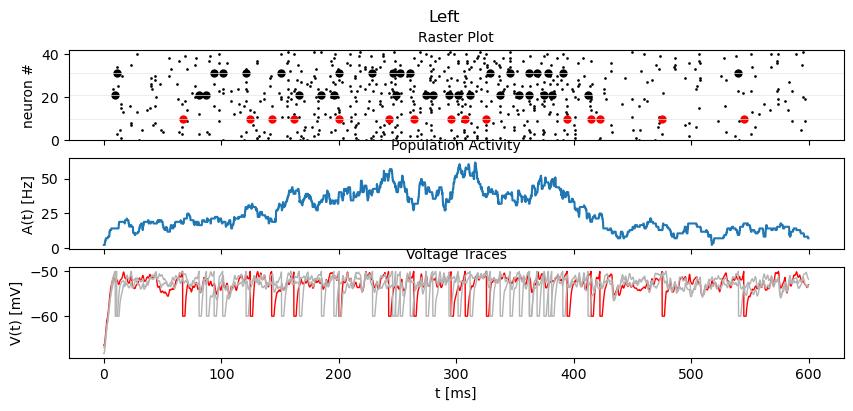

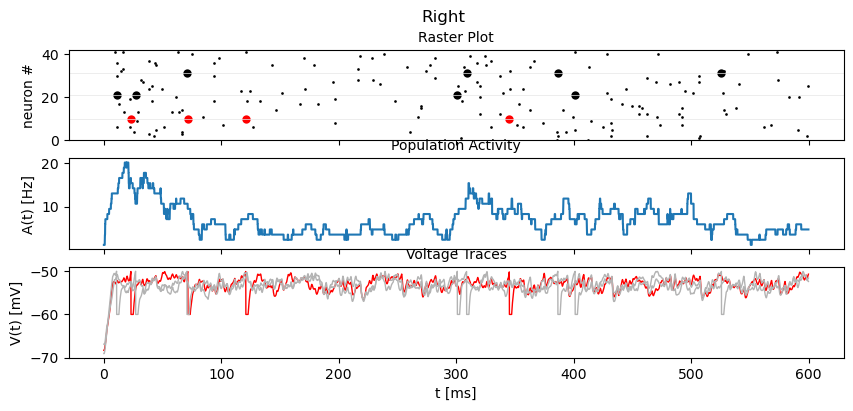

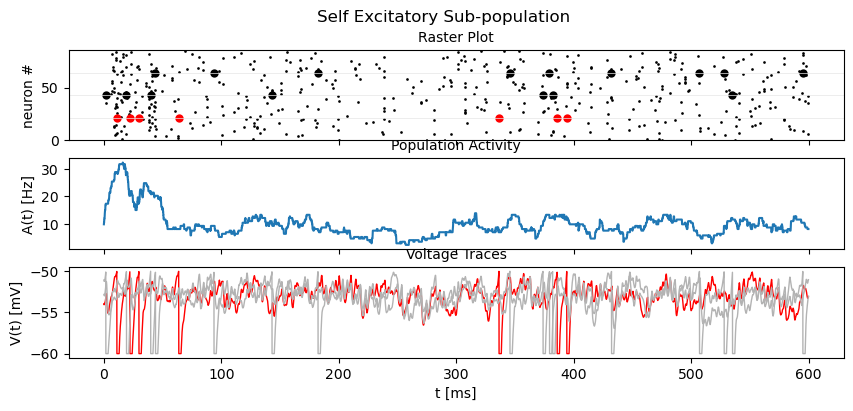

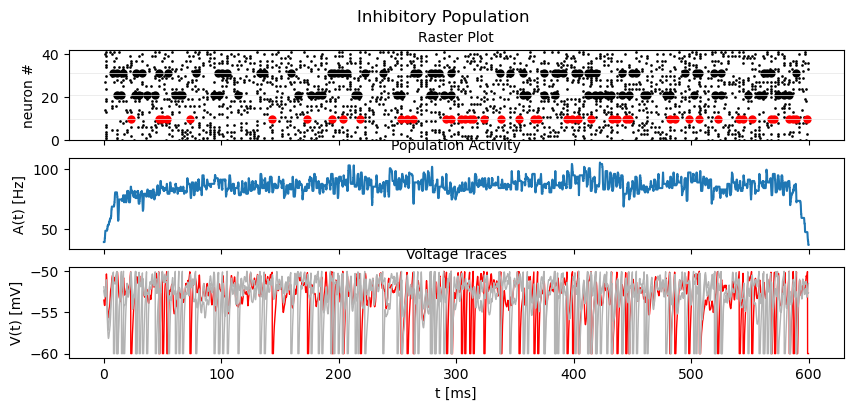

In [46]:
# The simulator we are using here to implement the network, Brian2, can create errors on subsequent runs
# to prevent this, make sure to delete all Brian2 objects (i.e. the monitor variables), before rerunning a simulation.
%reset_selective -f monitor

stim_start = 50. * b2.ms
stim_duration = 350 * b2.ms
print("stimulus start: {}, stimulus end: {}".format(stim_start, stim_start+stim_duration))
results = sim_decision_making_network(N_Excit=170, N_Inhib=42, weight_scaling_factor=6.0,
                                      t_stimulus_start=stim_start, t_stimulus_duration=stim_duration,
                                      coherence_level=+0.90, w_pos=2.0, mu0_mean_stimulus_Hz=500 * b2.Hz,
                                      max_sim_time=600. * b2.ms)

plot_network_activity(results["rate_monitor_A"], results["spike_monitor_A"],
                              results["voltage_monitor_A"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                              sup_title="Left")
plot_network_activity(results["rate_monitor_B"], results["spike_monitor_B"],
                              results["voltage_monitor_B"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                              sup_title="Right")

# Added:
plot_network_activity(results["rate_monitor_Z"], results["spike_monitor_Z"],
                              results["voltage_monitor_Z"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                              sup_title="Self Excitatory Sub-population")
plot_network_activity(results["rate_monitor_inhib"], results["spike_monitor_inhib"],
                              results["voltage_monitor_inhib"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                              sup_title="Inhibitory Population")


plt.show()

In [47]:
results.keys() # specifies all variables that are saved within this dictionary

dict_keys(['rate_monitor_A', 'spike_monitor_A', 'voltage_monitor_A', 'idx_monitored_neurons_A', 'rate_monitor_B', 'spike_monitor_B', 'voltage_monitor_B', 'idx_monitored_neurons_B', 'rate_monitor_Z', 'spike_monitor_Z', 'voltage_monitor_Z', 'idx_monitored_neurons_Z', 'rate_monitor_inhib', 'spike_monitor_inhib', 'voltage_monitor_inhib', 'idx_monitored_neurons_inhib'])

### 2.2
* Using the same `results` dictionary, plot the rates using different values for the average window width.

INFO       width adjusted from 30. ms to 30.1 ms [brian2.monitors.ratemonitor.adjusted_width]


(<Figure size 1000x400 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

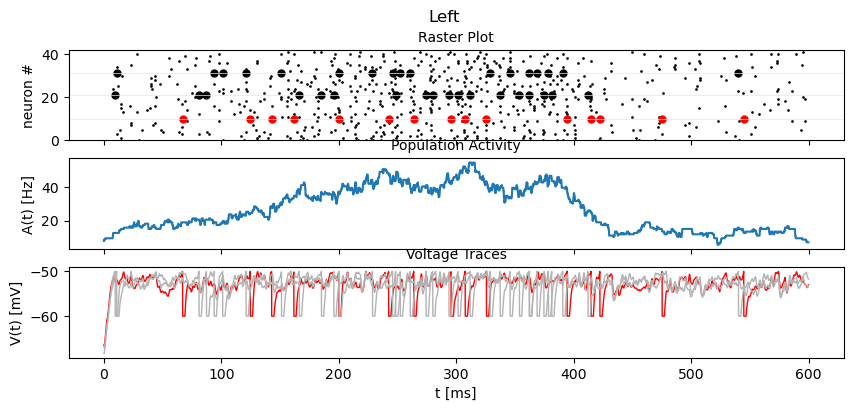

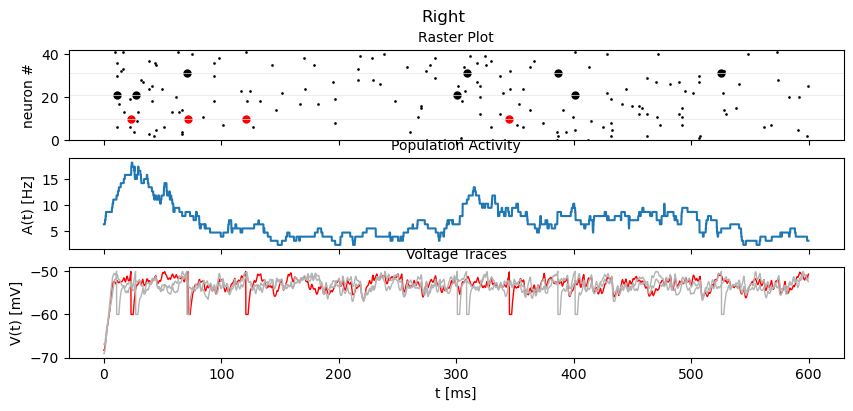

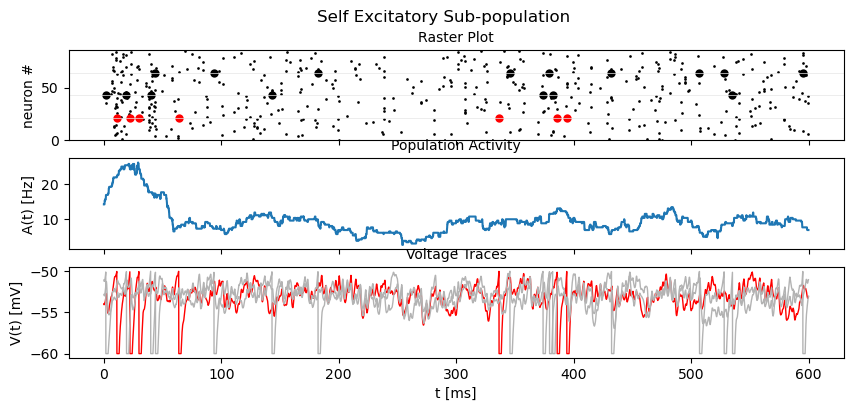

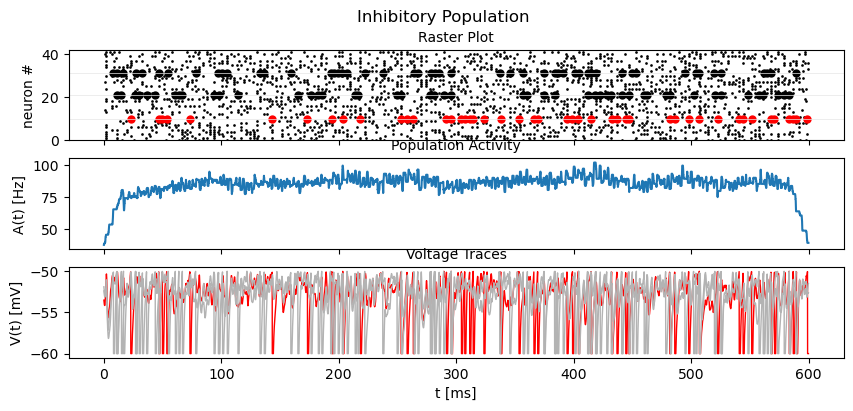

In [54]:
# q2.2
width = 30.

plot_network_activity(results["rate_monitor_A"], results["spike_monitor_A"],
                              results["voltage_monitor_A"], t_min=0. * b2.ms, avg_window_width=width * b2.ms,
                              sup_title="Left")
plot_network_activity(results["rate_monitor_B"], results["spike_monitor_B"],
                              results["voltage_monitor_B"], t_min=0. * b2.ms, avg_window_width=width * b2.ms,
                              sup_title="Right")

# Added:
plot_network_activity(results["rate_monitor_Z"], results["spike_monitor_Z"],
                              results["voltage_monitor_Z"], t_min=0. * b2.ms, avg_window_width=width * b2.ms,
                              sup_title="Self Excitatory Sub-population")
plot_network_activity(results["rate_monitor_inhib"], results["spike_monitor_inhib"],
                              results["voltage_monitor_inhib"], t_min=0. * b2.ms, avg_window_width=width * b2.ms,
                              sup_title="Inhibitory Population")
                              

### 2.3
* Interpret the effect of a very short and a very long averaging window.

* Is there a value for the average window width for which the population activity plot gives meaningful rates?

### 2.3 Results:

A very short window makes the mean very transient and vary a lot more as the spikes increase and decrease extremely quickly. The larger window makes the rolling mean use a wide range of spikes to calculate the mean. This causes a more flat population activity over the range.

No. There are many width values that could give a reasonable output. For example if I wanted to know the exact rate at any given time step I might use a very short range. But if I want to determine the average rate over stimulus vs over lack of stimulus I might use a larger width that covers the length of the input time period.

The input stimulus to the left and right subpopulations is implemented using two inhomogenous Poisson processes. This input has a coherence level $c$ and is noisy. In the implementation given here every 30ms, the firing rates $v_{left}$ and $v_{right}$ of each of the PoissonGroups are drawn from a normal distribution:

$$
\begin{aligned}
v_{\text {left }} & \sim \mathcal{N}\left(\mu_{\text {left }}, \sigma^{2}\right) \\
v_{\text {right }} & \sim \mathcal{N}\left(\mu_{\text {right }}, \sigma^{2}\right) \\
\mu_{\text {left }} &=\mu_{0} *(0.5+0.5 c) \\
\mu_{\text {right }} &=\mu_{0} *(0.5-0.5 c) \\
c & \in[-1,+1]
\end{aligned}
$$



### 2.4
* For the equation above, express the difference $\mu_{left} - \mu_{right}$ in terms of $\mu_0$ and $c$.

### 2.5
* Plot the distribution of the difference $v_{left} - v_{right}$. 

  Hint: the difference of two normally distributed Random Variables is another Gaussian distribution.

### 2.6
* What are the mean firing rates $\mu_{left}$ and $\mu_{right}$  (in Hz) for the coherence level $c=-0.2$?

### 2.4 Answer:

$\mu_0$ * $c$.

In [57]:
# 2.5 Answer:
import scipy.stats as sp
mu_0 = 1  #TODO
sigma = 1 #TODO
c = np.random.random_sample() # Maybe?

#sp.norm()

### 2.6 Answer

### 2.7
* Run a few simulations with $c=-0.1$ and $c=+0.6$. Plot the network activity.

    Does the network always make the correct decision?
    Look at the population rates and estimate how long it takes the network to make a decision.
